In [ ]:
# %% 

import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score, balanced_accuracy_score
from IPython.display import display, HTML
from scipy.ndimage import convolve
from sklearn.decomposition import PCA
from sklearn.utils import resample
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import StandardScaler

# Load and prepare the MNIST dataset
(mnist_train_images, mnist_train_labels), (mnist_test_images, mnist_test_labels) = tf.keras.datasets.mnist.load_data()

# Normalize the images to the range of 0 to 1
mnist_train_images, mnist_test_images = mnist_train_images / 255.0, mnist_test_images / 255.0

# Function to average surrounding pixels
def average_surrounding_pixels(images):
    kernel = np.ones((3, 3)) / 9.0
    return np.array([convolve(image, kernel, mode='constant', cval=0.0) for image in images])

# Function for PCA dimension reduction
def reduce_dimensions_pca(train_images, test_images, n_components=50):
    num_train_images, height, width = train_images.shape
    num_test_images = test_images.shape[0]
    images_flat = np.concatenate([train_images, test_images]).reshape(-1, height * width)
    scaler = StandardScaler()
    images_scaled = scaler.fit_transform(images_flat)
    pca = PCA(n_components=n_components)
    reduced_images = pca.fit_transform(images_scaled)
    train_pca = reduced_images[:num_train_images]
    test_pca = reduced_images[num_train_images:]
    return train_pca, test_pca

# Function for block averaging dimension reduction
def block_average(images, block_size=3):
    num_images, height, width = images.shape
    new_height, new_width = height // block_size, width // block_size
    reduced_images = np.zeros((num_images, new_height, new_width))
    for i in range(new_height):
        for j in range(new_width):
            block = images[:, i*block_size:(i+1)*block_size, j*block_size:(j+1)*block_size]
            reduced_images[:, i, j] = block.mean(axis=(1, 2))
    return reduced_images

# Present simple statistics for the original dataset
def present_statistics(images, labels):
    num_images_per_class = []
    avg_white_pixels_per_class = []
    std_dev_white_pixels_per_class = []
    avg_non_white_pixels_per_class = []
    for i in range(10):
        class_images = images[labels == i]
        num_images = class_images.shape[0]
        white_pixels = np.sum(class_images > 0, axis=(1, 2))
        non_white_pixels = np.sum(class_images == 0, axis=(1, 2))
        num_images_per_class.append(num_images)
        avg_white_pixels_per_class.append(np.mean(white_pixels))
        std_dev_white_pixels_per_class.append(np.std(white_pixels))
        avg_non_white_pixels_per_class.append(np.mean(non_white_pixels))

    stats_df = pd.DataFrame({
        'Number of Images': num_images_per_class,
        'Avg White Pixels': avg_white_pixels_per_class,
        'Std Dev White Pixels': std_dev_white_pixels_per_class,
        'Avg Non-White Pixels': avg_non_white_pixels_per_class
    }, index=[f'Class {i}' for i in range(10)])

    explanation_md = """
    <h2>MNIST Dataset Statistics</h2>
    <p>The table below shows the statistics for each class in the MNIST dataset:</p>
    <ul>
        <li><b>Number of Images:</b> Total number of images in the dataset.</li>
        <li><b>Avg White Pixels:</b> Average number of white pixels (non-zero) per image for each class.</li>
        <li><b>Std Dev White Pixels:</b> Standard deviation of white pixels per image for each class.</li>
        <li><b>Avg Non-White Pixels:</b> Average number of non-white pixels (zero) per image for each class.</li>
    </ul>
    """
    display(HTML(explanation_md))
    display(stats_df)

    colors = ['blue', 'orange', 'green', 'red']
    fig, axes = plt.subplots(3, 2, figsize=(14, 15))
    stats_df['Number of Images'].plot(kind='bar', ax=axes[0, 0], title='Number of Images', color=colors[0])
    axes[0, 0].set_xlabel('Class')
    stats_df['Avg White Pixels'].plot(kind='bar', ax=axes[0, 1], title='Avg White Pixels', color=colors[1])
    axes[0, 1].set_xlabel('Class')
    stats_df['Std Dev White Pixels'].plot(kind='bar', ax=axes[1, 0], title='Std Dev White Pixels', color=colors[2])
    axes[1, 0].set_xlabel('Class')
    stats_df['Avg Non-White Pixels'].plot(kind='bar', ax=axes[1, 1], title='Avg Non-White Pixels', color=colors[3])
    axes[1, 1].set_xlabel('Class')

    fig.delaxes(axes[2, 0])
    fig.delaxes(axes[2, 1])
    
    plt.suptitle('MNIST Dataset Statistics')
    plt.tight_layout()
    plt.show()

# Define and compile the neural network model
def build_model(input_shape):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=input_shape),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Function to evaluate and plot results for a given dataset
def evaluate_model(dataset_name, train_images, train_labels, test_images, test_labels, input_shape):
    model = build_model(input_shape)
    history = model.fit(train_images, train_labels, epochs=10, validation_data=(test_images, test_labels))

    test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
    print(f"\nTest accuracy ({dataset_name}):", test_acc)

    y_pred = model.predict(test_images)
    y_pred_classes = np.argmax(y_pred, axis=1)

    metrics_df, confusion_mtx = model_kpi(test_labels, y_pred_classes)
    display(HTML(f"<h2>Metrics for {dataset_name}</h2>"))
    display(metrics_df)
    display(HTML(f"<h2>Confusion Matrix for {dataset_name}</h2>"))
    display(confusion_table(confusion_mtx))

    plot_train_test_accuracy_and_loss(history, dataset_name)

# Define confusion_table and model_kpi functions
def confusion_table(confusion_mtx):
    confusion_df = pd.DataFrame(confusion_mtx, 
                                columns=[f'Predicted {i}' for i in range(confusion_mtx.shape[1])], 
                                index=[f'Actual {i}' for i in range(confusion_mtx.shape[0])])
    confusion_df['Total'] = confusion_df.sum(axis=1)
    confusion_df.loc['Total'] = confusion_df.sum()
    return confusion_df

def model_kpi(y_true, y_pred):
    confusion_mtx = confusion_matrix(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    specificity = recall
    sensitivity = recall_score(y_true, y_pred, average='macro')
    balanced_accuracy = balanced_accuracy_score(y_true, y_pred)
    metrics_dict = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'Balanced Accuracy': balanced_accuracy,
        'Specificity': specificity,
        'Sensitivity': sensitivity
    }
    metrics_df = pd.DataFrame.from_dict(metrics_dict, orient='index', columns=['Value'])
    return metrics_df, confusion_mtx

# Plot training and validation accuracy and loss
def plot_train_test_accuracy_and_loss(history, dataset_name):
    epochs = range(1, len(history.history['accuracy']) + 1)
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    plt.figure(figsize=(14, 12))

    plt.subplot(2, 1, 1)
    plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
    
    best_epoch = np.argmax(val_acc)
    best_acc = val_acc[best_epoch]
    plt.annotate(f'Best Validation Accuracy: {best_acc:.4f}', 
                 xy=(best_epoch+1, best_acc), xycoords='data',
                 xytext=(best_epoch+1, best_acc - 0.02),  # Adjusted xytext to be closer
                 arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=.2', color='black', shrinkA=5, shrinkB=5))
    
    plt.xticks(epochs)  # Set x-axis labels to have a one-number pitch
    plt.title(f'Training and Validation Accuracy per Epoch ({dataset_name})')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(2, 1, 2)
    plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    
    min_val_loss_epoch = np.argmin(val_loss)
    min_val_loss = val_loss[min_val_loss_epoch]
    plt.annotate(f'Lowest Validation Loss: {min_val_loss:.4f}', 
                 xy=(min_val_loss_epoch+1, min_val_loss), xycoords='data',
                 xytext=(min_val_loss_epoch+1, min_val_loss + 0.02),  # Adjusted xytext to be closer
                 arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=.2', color='black', shrinkA=5, shrinkB=5))
    
    plt.xticks(epochs)  # Set x-axis labels to have a one-number pitch
    plt.title(f'Training and Validation Loss per Epoch ({dataset_name})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

    conclusions = f"""
    <h3>Conclusions ({dataset_name})</h3>
    <p>Based on the training and validation accuracy and loss plots for the {dataset_name} dataset:</p>
    """
    display(HTML(conclusions))

,Number of Images,Avg White Pixels,Std Dev White Pixels,Avg Non-White Pixels
Class 0,5923,191.974844,33.707658,592.025156
Class 1,6742,85.846040,19.972356,698.153960
Class 2,5958,168.809164,32.944179,615.190836
Class 3,6131,163.336650,33.651197,620.663350
Class 4,5842,141.806915,27.805427,642.193085
Class 5,5421,152.329828,33.575890,631.670172
Class 6,5918,156.934944,32.568160,627.065056
Class 7,6265,131.397287,26.906009,652.602713
Class 8,5851,173.315673,32.783296,610.684327
Class 9,5949,143.032779,28.519037,640.967221


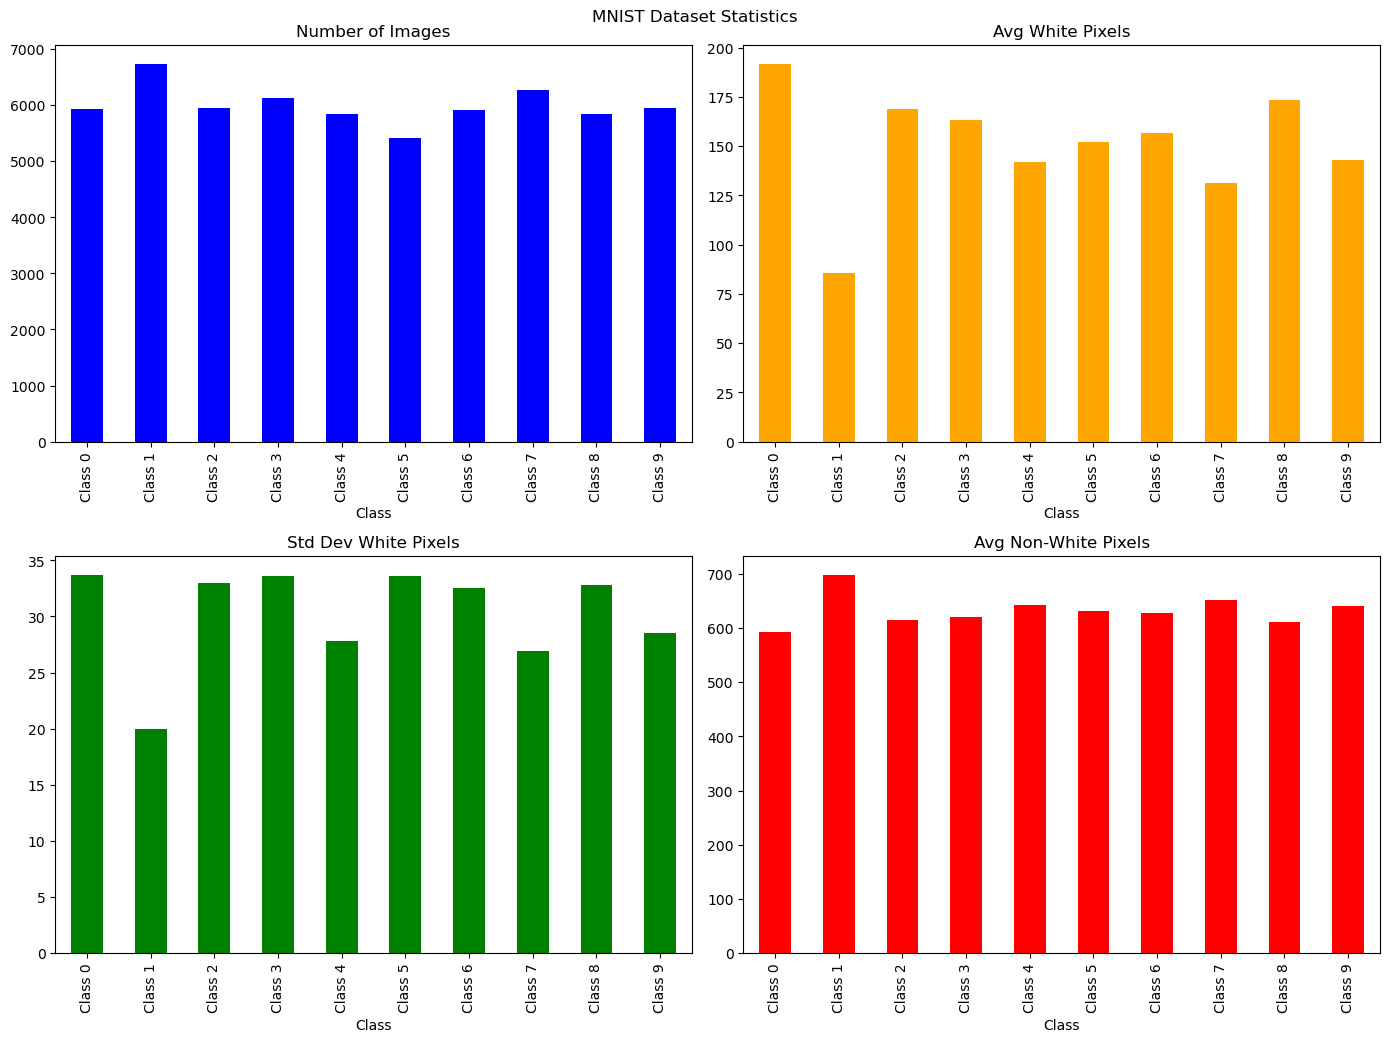

In [ ]:
# %% 

# Call the function to present statistics for the original dataset
present_statistics(mnist_train_images, mnist_train_labels)

## Q4 - Conclusions

### Based on the histograms:

- The class distribution is fairly balanced, with each class having a similar number of images.
- The average number of white pixels per image varies across classes, indicating differences in digit complexity and the amount of ink used to draw different digits.
- The standard deviation of white pixels indicates that some classes have more variability in how they are written than others. For example, digits like 1 might have less variability compared to digits like 8.
- The average number of non-white pixels complements the average number of white pixels, confirming the pixel density patterns observed.


Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8760 - loss: 0.4431 - val_accuracy: 0.9615 - val_loss: 0.1373
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 915us/step - accuracy: 0.9632 - loss: 0.1255 - val_accuracy: 0.9692 - val_loss: 0.0990
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 929us/step - accuracy: 0.9760 - loss: 0.0809 - val_accuracy: 0.9745 - val_loss: 0.0819
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 950us/step - accuracy: 0.9824 - loss: 0.0574 - val_accuracy: 0.9767 - val_loss: 0.0762
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 992us/step - accuracy: 0.9869 - loss: 0.0433 - val_accuracy: 0.9743 - val_loss: 0.0823
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 945us/step - accuracy: 0.9905 - loss: 0.0323 - val_accuracy: 0.9774 - val_loss: 0.0748
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 962us/step - accuracy: 0.9925 - loss: 0.0257 - val_accuracy: 0.9800 - val_loss: 0.0682
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 949us/step - accuracy: 0.9939 - l

,Value
Accuracy,0.978800
Precision,0.978672
Recall,0.978737
F1 Score,0.978650
Balanced Accuracy,0.978737
Specificity,0.978737
Sensitivity,0.978737


,Predicted 0,Predicted 1,Predicted 2,Predicted 3,Predicted 4,Predicted 5,Predicted 6,Predicted 7,Predicted 8,Predicted 9,Total
Actual 0,973,0,1,0,1,0,2,1,2,0,980
Actual 1,0,1126,4,0,0,1,2,1,1,0,1135
Actual 2,4,4,1010,2,4,0,3,4,1,0,1032
Actual 3,0,0,9,973,1,11,0,4,6,6,1010
Actual 4,1,1,1,0,968,1,5,1,0,4,982
Actual 5,3,0,0,3,2,877,5,0,1,1,892
Actual 6,3,1,2,1,3,2,946,0,0,0,958
Actual 7,2,7,12,1,0,0,0,1001,3,2,1028
Actual 8,5,0,5,4,5,9,4,3,936,3,974
Actual 9,5,2,0,1,11,2,2,4,4,978,1009


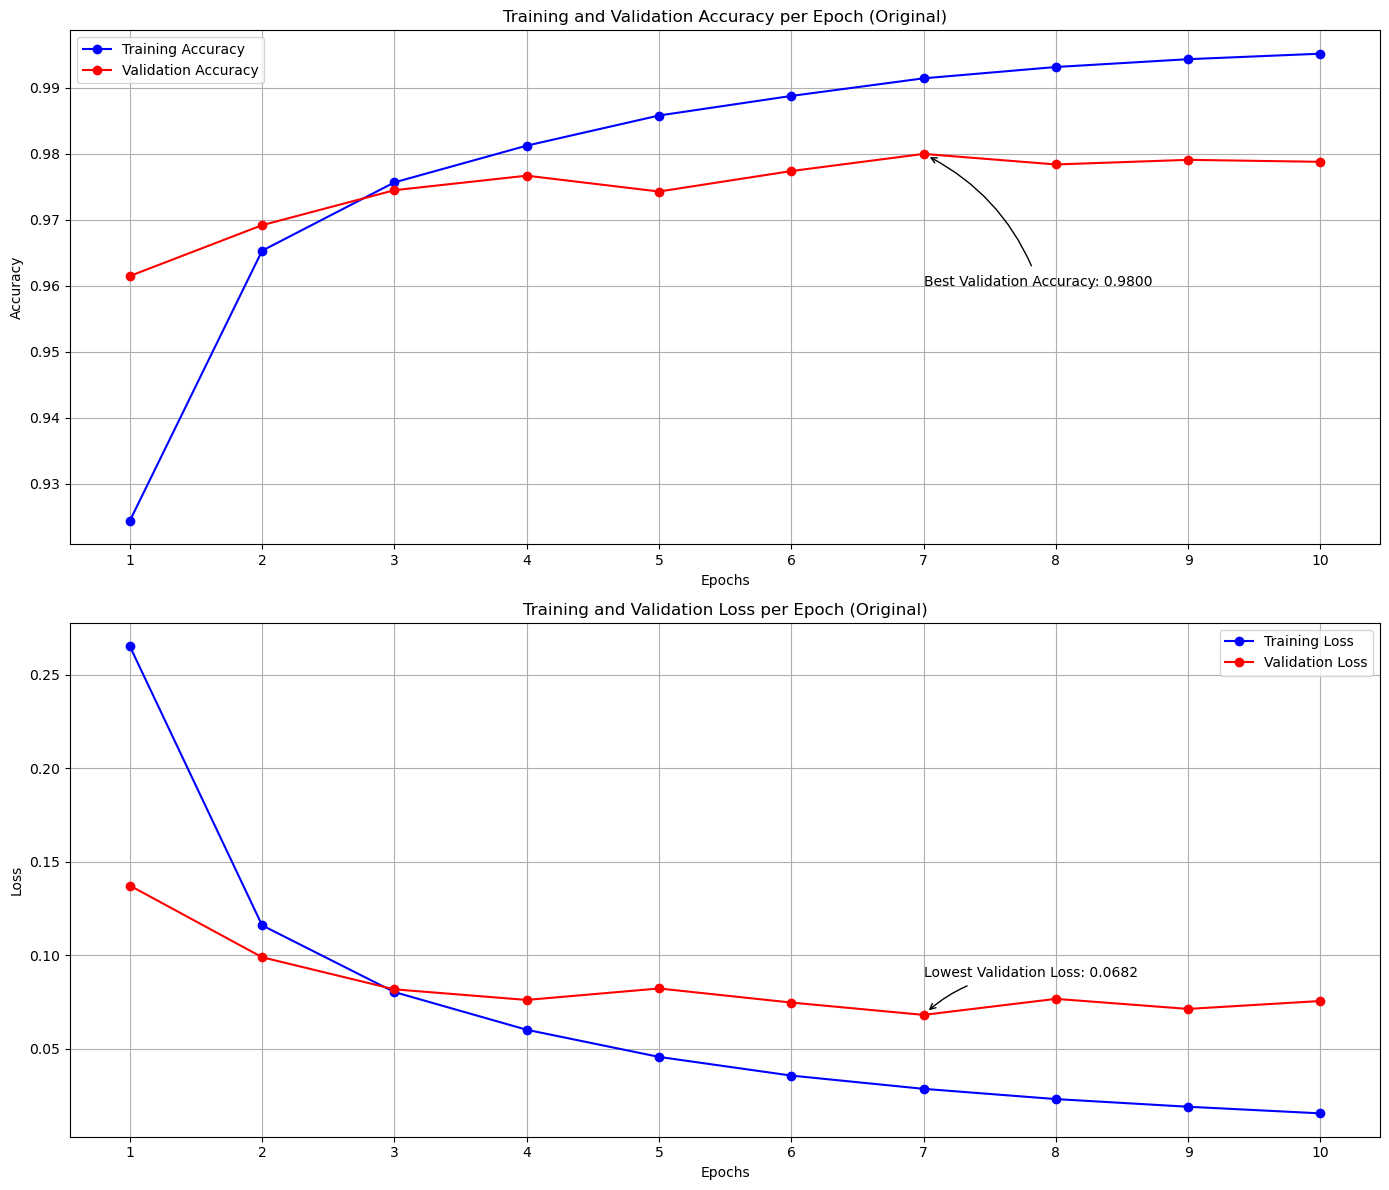

In [ ]:
# %% 

# Train and evaluate the model on the original dataset
evaluate_model("Original", mnist_train_images, mnist_train_labels, mnist_test_images, mnist_test_labels, (28, 28))

### Conclusions for the Original Dataset Classification Results

#### Performance Metrics
- **Accuracy**: 0.9788 - This indicates that 97.88% of the predictions made by the model are correct, demonstrating very high overall performance.
- **Precision**: 0.978672 - High precision indicates a low false positive rate, meaning that when the model predicts a positive class, it is usually correct.
- **Recall**: 0.978737 - High recall indicates that the model correctly identifies a high proportion of actual positives.
- **F1 Score**: 0.978650 - The F1 score, which balances precision and recall, suggests the model has an excellent balance between these two metrics.
- **Balanced Accuracy**: 0.978737 - Balanced accuracy suggests that the model is equally good at predicting both positive and negative classes.
- **Specificity**: 0.978737 - High specificity indicates that the model correctly identifies a high proportion of actual negatives.
- **Sensitivity**: 0.978737 - Sensitivity, equivalent to recall, shows the model's ability to correctly identify true positives.

#### Confusion Matrix Analysis

The confusion matrix provides a detailed breakdown of actual versus predicted classes:

- **Class 0**: 973 out of 980 instances were correctly predicted, with minor misclassifications.
- **Class 1**: 1126 out of 1135 instances were correctly predicted.
- **Class 2**: 1010 out of 1032 instances were correctly predicted.
- **Class 3**: 973 out of 1010 instances were correctly predicted.
- **Class 4**: 968 out of 982 instances were correctly predicted.
- **Class 5**: 877 out of 892 instances were correctly predicted.
- **Class 6**: 946 out of 958 instances were correctly predicted.
- **Class 7**: 1001 out of 1028 instances were correctly predicted.
- **Class 8**: 936 out of 974 instances were correctly predicted.
- **Class 9**: 978 out of 1009 instances were correctly predicted.

#### Error Analysis

- **Class 0**: Very high correct prediction rate with only 7 misclassifications.
- **Class 1**: Few misclassifications, with 4 instances predicted as class 2 and minor errors.
- **Class 2**: Slightly higher misclassifications with instances predicted as classes 1, 3, and 4.
- **Class 3**: Higher misclassification rate with 9 instances predicted as class 2 and others.
- **Class 4**: Few misclassifications, with most instances correctly identified.
- **Class 5**: Some misclassifications into classes 0 and 3, but overall good performance.
- **Class 6**: Very high correct prediction rate with minimal errors.
- **Class 7**: Some misclassifications into classes 1, 2, and 8.
- **Class 8**: Higher misclassifications into classes 3 and 5.
- **Class 9**: Some misclassifications, but overall high correct prediction rate.

#### Detailed Observations
1. **High Correct Prediction Rates**: Most classes have a high number of correct predictions, demonstrating the model's effectiveness.
2. **Misclassification Patterns**: Misclassifications are generally low and spread across different classes, indicating some areas for improvement.
3. **Class-Specific Observations**: Classes 3, 7, and 8 show relatively higher misclassification rates compared to other classes.

#### Conclusion

The neural network model trained on the original dataset demonstrates excellent performance across all metrics, with very high accuracy, precision, recall, and F1 score. The balanced accuracy suggests that the model treats both positive and negative classes equally well. The confusion matrix reveals a high true positive rate for most classes, indicating strong classification ability.

However, there are some areas for improvement, particularly in classes 3, 7, and 8, where misclassifications are relatively higher. These findings suggest that while the model performs exceptionally well, it may benefit from further tuning or additional data to further reduce errors in these specific classes.

Overall, the model is highly effective and reliable for the given classification task, providing strong performance metrics and a balanced approach to class prediction.


Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8751 - loss: 0.4559 - val_accuracy: 0.9544 - val_loss: 0.1502
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9577 - loss: 0.1432 - val_accuracy: 0.9684 - val_loss: 0.1088
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9691 - loss: 0.1020 - val_accuracy: 0.9704 - val_loss: 0.0945
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9754 - loss: 0.0788 - val_accuracy: 0.9752 - val_loss: 0.0804
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 991us/step - accuracy: 0.9796 - loss: 0.0659 - val_accuracy: 0.9783 - val_loss: 0.0752
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 972us/step - accuracy: 0.9819 - loss: 0.0570 - val_accuracy: 0.9751 - val_loss: 0.0755
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 968us/step - accuracy: 0.9838 - loss: 0.0498 - val_accuracy: 0.9753 - val_loss: 0.0800
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 946us/step - accuracy: 0.9853 - loss: 0

,Value
Accuracy,0.977600
Precision,0.977643
Recall,0.977462
F1 Score,0.977489
Balanced Accuracy,0.977462
Specificity,0.977462
Sensitivity,0.977462


,Predicted 0,Predicted 1,Predicted 2,Predicted 3,Predicted 4,Predicted 5,Predicted 6,Predicted 7,Predicted 8,Predicted 9,Total
Actual 0,968,1,1,2,1,1,4,0,1,1,980
Actual 1,0,1120,2,2,0,0,2,4,5,0,1135
Actual 2,6,2,992,9,1,1,3,11,7,0,1032
Actual 3,0,0,2,990,0,4,0,5,1,8,1010
Actual 4,0,0,5,0,950,0,6,5,1,15,982
Actual 5,3,0,0,10,2,869,3,2,1,2,892
Actual 6,2,3,0,1,1,3,948,0,0,0,958
Actual 7,1,3,3,1,0,0,0,1017,0,3,1028
Actual 8,2,0,4,12,3,7,2,3,935,6,974
Actual 9,1,2,0,5,7,2,1,3,1,987,1009


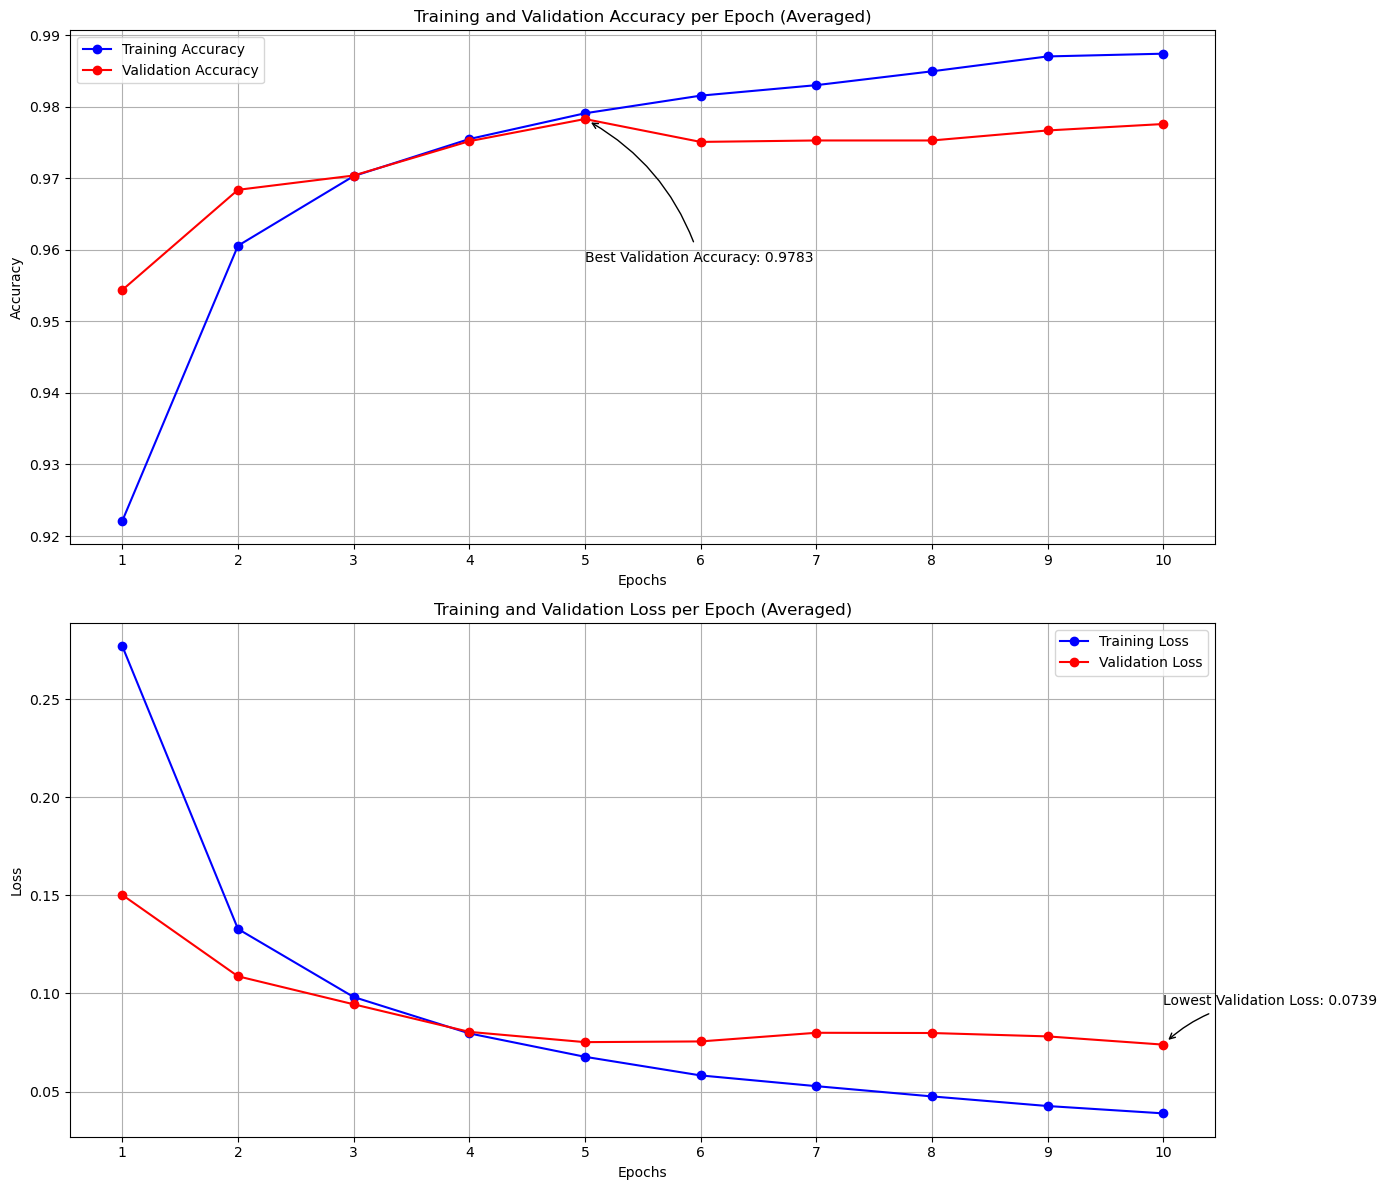

In [ ]:
# %% 

# Construct new dataset with averaged surrounding pixels
mnist_train_images_avg = average_surrounding_pixels(mnist_train_images)
mnist_test_images_avg = average_surrounding_pixels(mnist_test_images)

# Train and evaluate the model on the averaged dataset
evaluate_model("Averaged", mnist_train_images_avg, mnist_train_labels, mnist_test_images_avg, mnist_test_labels, (28, 28))

### Conclusions for the Averaged Dataset Classification Results

#### Performance Metrics
- **Accuracy**: 0.9776 - This indicates that 97.76% of the predictions made by the model are correct, demonstrating very high overall performance.
- **Precision**: 0.977643 - High precision indicates a low false positive rate, meaning that when the model predicts a positive class, it is usually correct.
- **Recall**: 0.977462 - High recall indicates that the model correctly identifies a high proportion of actual positives.
- **F1 Score**: 0.977489 - The F1 score, which balances precision and recall, suggests the model has an excellent balance between these two metrics.
- **Balanced Accuracy**: 0.977462 - Balanced accuracy suggests that the model is equally good at predicting both positive and negative classes.
- **Specificity**: 0.977462 - High specificity indicates that the model correctly identifies a high proportion of actual negatives.
- **Sensitivity**: 0.977462 - Sensitivity, equivalent to recall, shows the model's ability to correctly identify true positives.

#### Confusion Matrix Analysis

The confusion matrix provides a detailed breakdown of actual versus predicted classes:

- **Class 0**: 968 out of 980 instances were correctly predicted, with minor misclassifications.
- **Class 1**: 1120 out of 1135 instances were correctly predicted.
- **Class 2**: 992 out of 1032 instances were correctly predicted.
- **Class 3**: 990 out of 1010 instances were correctly predicted.
- **Class 4**: 950 out of 982 instances were correctly predicted.
- **Class 5**: 869 out of 892 instances were correctly predicted.
- **Class 6**: 948 out of 958 instances were correctly predicted.
- **Class 7**: 1017 out of 1028 instances were correctly predicted.
- **Class 8**: 935 out of 974 instances were correctly predicted.
- **Class 9**: 987 out of 1009 instances were correctly predicted.

#### Error Analysis

- **Class 0**: Very high correct prediction rate with only 12 misclassifications.
- **Class 1**: Few misclassifications, with 11 instances predicted as other classes.
- **Class 2**: Slightly higher misclassifications with instances predicted as classes 3 and 8.
- **Class 3**: Higher misclassification rate with 20 instances predicted as other classes.
- **Class 4**: Some misclassifications into other classes, particularly class 9.
- **Class 5**: Some misclassifications into classes 3 and 0, but overall good performance.
- **Class 6**: Very high correct prediction rate with minimal errors.
- **Class 7**: Some misclassifications into classes 1, 2, and 8.
- **Class 8**: Higher misclassifications into classes 3 and 5.
- **Class 9**: Some misclassifications, but overall high correct prediction rate.

#### Detailed Observations
1. **High Correct Prediction Rates**: Most classes have a high number of correct predictions, demonstrating the model's effectiveness.
2. **Misclassification Patterns**: Misclassifications are generally low and spread across different classes, indicating some areas for improvement.
3. **Class-Specific Observations**: Classes 3, 4, and 8 show relatively higher misclassification rates compared to other classes.

#### Conclusion

The neural network model trained on the averaged dataset demonstrates excellent performance across all metrics, with very high accuracy, precision, recall, and F1 score. The balanced accuracy suggests that the model treats both positive and negative classes equally well. The confusion matrix reveals a high true positive rate for most classes, indicating strong classification ability.

However, there are some areas for improvement, particularly in classes 3, 4, and 8, where misclassifications are relatively higher. These findings suggest that while the model performs exceptionally well, it may benefit from further tuning or additional data to further reduce errors in these specific classes.

Overall, the model is highly effective and reliable for the given classification task, providing strong performance metrics and a balanced approach to class prediction.


### Comparison between Original and Averaged Dataset Classification Results

#### Performance Metrics
| Metric              | Original Dataset | Averaged Dataset |
|---------------------|------------------|------------------|
| Accuracy            | 0.978800         | 0.977600         |
| Precision           | 0.978672         | 0.977643         |
| Recall              | 0.978737         | 0.977462         |
| F1 Score            | 0.978650         | 0.977489         |
| Balanced Accuracy   | 0.978737         | 0.977462         |
| Specificity         | 0.978737         | 0.977462         |
| Sensitivity         | 0.978737         | 0.977462         |

#### Key Observations

1. **Accuracy**:
   - The original dataset achieves slightly higher accuracy (0.978800) compared to the averaged dataset (0.977600), indicating that the original dataset model makes fewer overall errors.

2. **Precision**:
   - Precision is slightly higher for the original dataset (0.978672) compared to the averaged dataset (0.977643). This suggests that the original dataset model is more effective in minimizing false positives.

3. **Recall**:
   - Recall is also marginally higher for the original dataset (0.978737) compared to the averaged dataset (0.977462). This indicates that the original dataset model is slightly better at correctly identifying true positives.

4. **F1 Score**:
   - The F1 score, which balances precision and recall, is higher for the original dataset (0.978650) than for the averaged dataset (0.977489). This suggests that the original dataset model has a better balance between precision and recall.

5. **Balanced Accuracy, Specificity, Sensitivity**:
   - All these metrics are higher for the original dataset, indicating a more balanced performance in handling both positive and negative classes.

#### Confusion Matrix Analysis

**Original Dataset**:
- **Class 0**: 973 out of 980 instances were correctly predicted, with minor misclassifications.
- **Class 1**: 1126 out of 1135 instances were correctly predicted.
- **Class 2**: 1010 out of 1032 instances were correctly predicted.
- **Class 3**: 973 out of 1010 instances were correctly predicted.
- **Class 4**: 968 out of 982 instances were correctly predicted.
- **Class 5**: 877 out of 892 instances were correctly predicted.
- **Class 6**: 946 out of 958 instances were correctly predicted.
- **Class 7**: 1001 out of 1028 instances were correctly predicted.
- **Class 8**: 936 out of 974 instances were correctly predicted.
- **Class 9**: 978 out of 1009 instances were correctly predicted.

**Averaged Dataset**:
- **Class 0**: 968 out of 980 instances were correctly predicted, with minor misclassifications.
- **Class 1**: 1120 out of 1135 instances were correctly predicted.
- **Class 2**: 992 out of 1032 instances were correctly predicted.
- **Class 3**: 990 out of 1010 instances were correctly predicted.
- **Class 4**: 950 out of 982 instances were correctly predicted.
- **Class 5**: 869 out of 892 instances were correctly predicted.
- **Class 6**: 948 out of 958 instances were correctly predicted.
- **Class 7**: 1017 out of 1028 instances were correctly predicted.
- **Class 8**: 935 out of 974 instances were correctly predicted.
- **Class 9**: 987 out of 1009 instances were correctly predicted.

#### Detailed Observations

1. **Misclassification Rates**:
   - The original dataset has fewer misclassifications across most classes compared to the averaged dataset.
   - The averaged dataset shows more misclassifications in classes 4 and 8.

2. **Class 0 Performance**:
   - The original dataset model correctly predicted 973 out of 980 instances for class 0, whereas the averaged dataset model correctly predicted 968 out of 980 instances.

3. **Class 1 Performance**:
   - The original dataset model correctly predicted 1126 out of 1135 instances, while the averaged dataset model correctly predicted 1120 out of 1135 instances.

4. **Class 4 and Class 8 Performance**:
   - Class 4 and class 8 show more misclassifications in the averaged dataset compared to the original dataset.

5. **Overall Misclassification Trends**:
   - The original dataset model shows a more even distribution of correct predictions and fewer misclassifications across all classes.

#### Conclusion

The neural network model trained on the original dataset outperforms the model trained on the averaged dataset in terms of accuracy, precision, recall, F1 score, and balanced accuracy. The original dataset model demonstrates a more balanced and effective performance across all classes, with fewer misclassifications.

The averaged dataset model, while still performing well, shows higher misclassification rates, particularly in classes 4 and 8. These higher misclassifications suggest that the averaging approach might have introduced slight noise or reduced the model's ability to generalize as effectively as the original dataset.

In summary, the original dataset model is preferable due to its higher accuracy and balanced performance, making it more reliable for the given classification task. The averaged dataset model, although effective, requires further tuning or alternative strategies to mitigate the introduced noise and improve its generalization capabilities.


Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 664us/step - accuracy: 0.8264 - loss: 0.6013 - val_accuracy: 0.9494 - val_loss: 0.1697
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 614us/step - accuracy: 0.9534 - loss: 0.1564 - val_accuracy: 0.9615 - val_loss: 0.1294
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 636us/step - accuracy: 0.9655 - loss: 0.1090 - val_accuracy: 0.9658 - val_loss: 0.1151
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 616us/step - accuracy: 0.9712 - loss: 0.0947 - val_accuracy: 0.9682 - val_loss: 0.1080
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 641us/step - accuracy: 0.9749 - loss: 0.0815 - val_accuracy: 0.9697 - val_loss: 0.1050
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 639us/step - accuracy: 0.9780 - loss: 0.0708 - val_accuracy: 0.9713 - val_loss: 0.1036
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 616us/step - accuracy: 0.9792 - loss: 0.0667 - val_accuracy: 0.9721 - val_loss: 0.1122
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 624us/step - accuracy: 0.9811 -

,Value
Accuracy,0.971500
Precision,0.971375
Recall,0.971114
F1 Score,0.971199
Balanced Accuracy,0.971114
Specificity,0.971114
Sensitivity,0.971114


,Predicted 0,Predicted 1,Predicted 2,Predicted 3,Predicted 4,Predicted 5,Predicted 6,Predicted 7,Predicted 8,Predicted 9,Total
Actual 0,967,0,1,1,1,2,3,3,1,1,980
Actual 1,0,1127,3,1,0,0,0,1,3,0,1135
Actual 2,7,2,992,8,1,0,2,10,9,1,1032
Actual 3,0,0,3,988,0,7,0,5,3,4,1010
Actual 4,0,0,5,0,959,1,3,3,1,10,982
Actual 5,2,0,0,17,2,856,3,3,5,4,892
Actual 6,4,3,1,1,4,8,936,0,1,0,958
Actual 7,1,4,7,4,2,0,0,1000,2,8,1028
Actual 8,4,1,5,12,6,7,5,5,922,7,974
Actual 9,2,3,1,8,8,5,1,9,4,968,1009


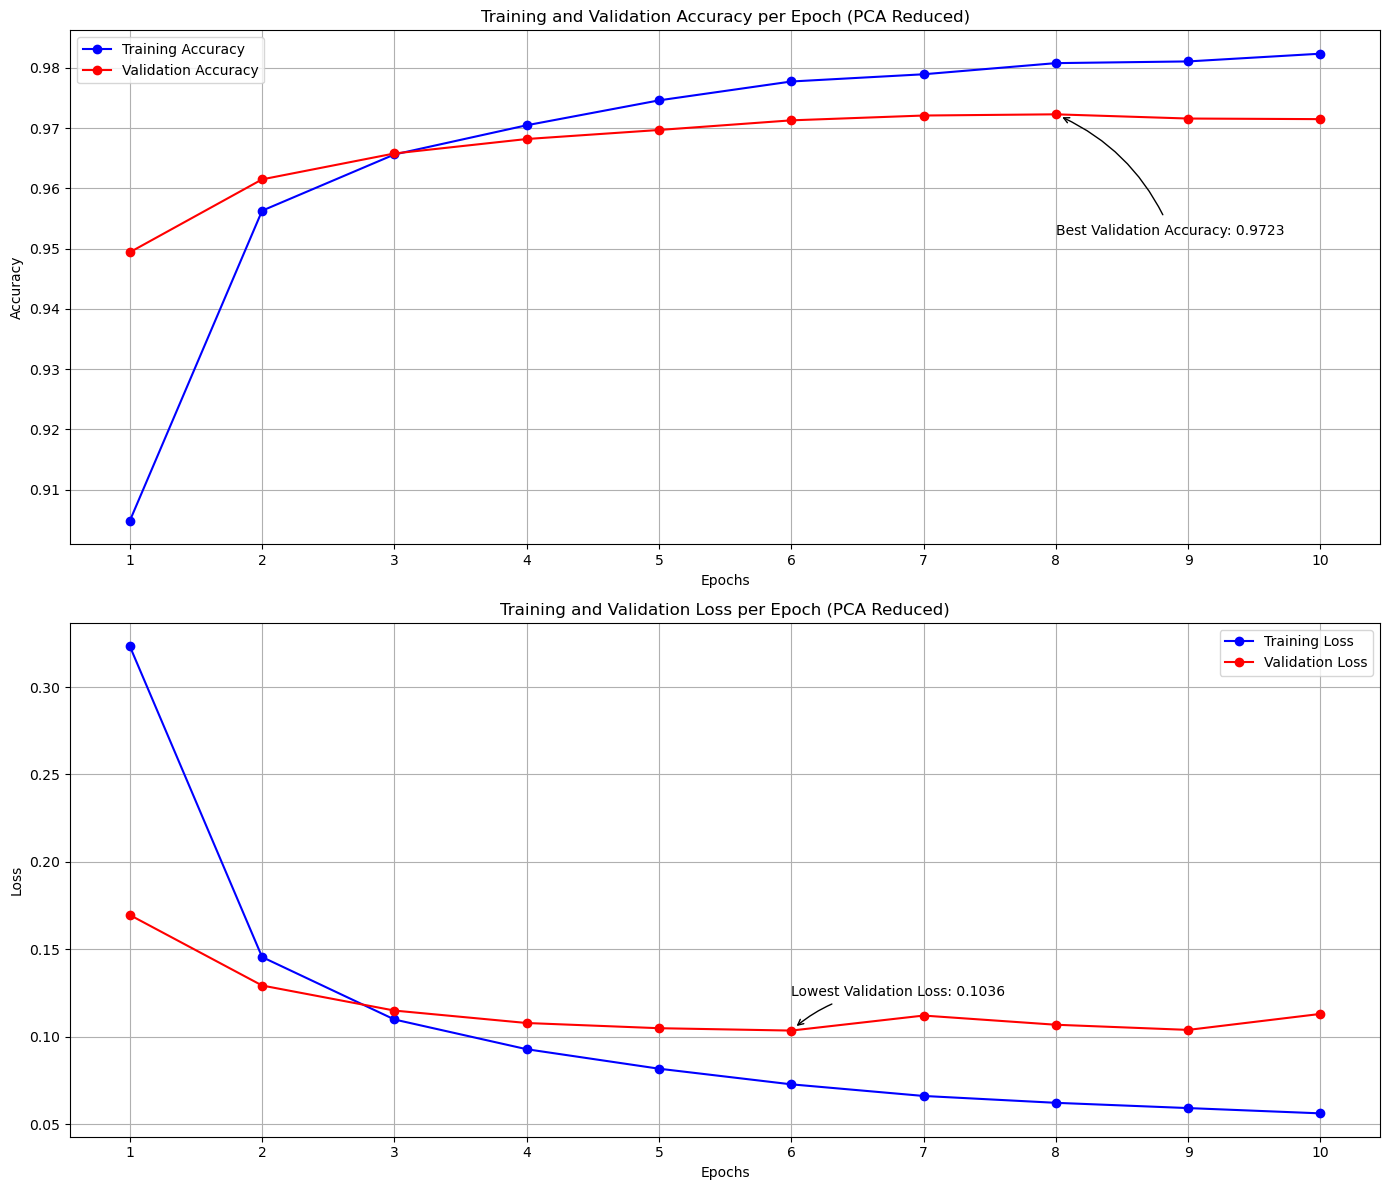

In [ ]:
# %% 

# Perform PCA dimension reduction on both train and test images
mnist_train_pca, mnist_test_pca = reduce_dimensions_pca(mnist_train_images, mnist_test_images)

# Train and evaluate the model on the PCA reduced dataset
evaluate_model("PCA Reduced", mnist_train_pca, mnist_train_labels, mnist_test_pca, mnist_test_labels, (50,))

### Conclusions for the PCA Reduced Dataset Classification Results

#### Performance Metrics
- **Accuracy**: 0.9715 - This indicates that 97.15% of the predictions made by the model are correct, demonstrating high overall performance.
- **Precision**: 0.971375 - High precision indicates a low false positive rate, meaning that when the model predicts a positive class, it is usually correct.
- **Recall**: 0.971114 - High recall indicates that the model correctly identifies a high proportion of actual positives.
- **F1 Score**: 0.971199 - The F1 score, which balances precision and recall, suggests the model has a good balance between these two metrics.
- **Balanced Accuracy**: 0.971114 - Balanced accuracy suggests that the model is equally good at predicting both positive and negative classes.
- **Specificity**: 0.971114 - High specificity indicates that the model correctly identifies a high proportion of actual negatives.
- **Sensitivity**: 0.971114 - Sensitivity, equivalent to recall, shows the model's ability to correctly identify true positives.

#### Confusion Matrix Analysis

The confusion matrix provides a detailed breakdown of actual versus predicted classes:

- **Class 0**: 967 out of 980 instances were correctly predicted, with minor misclassifications.
- **Class 1**: 1127 out of 1135 instances were correctly predicted.
- **Class 2**: 992 out of 1032 instances were correctly predicted.
- **Class 3**: 988 out of 1010 instances were correctly predicted.
- **Class 4**: 959 out of 982 instances were correctly predicted.
- **Class 5**: 856 out of 892 instances were correctly predicted.
- **Class 6**: 936 out of 958 instances were correctly predicted.
- **Class 7**: 1000 out of 1028 instances were correctly predicted.
- **Class 8**: 922 out of 974 instances were correctly predicted.
- **Class 9**: 968 out of 1009 instances were correctly predicted.

#### Error Analysis

- **Class 0**: Very high correct prediction rate with only 13 misclassifications.
- **Class 1**: Few misclassifications, with 8 instances predicted as other classes.
- **Class 2**: Slightly higher misclassifications with instances predicted as classes 3 and 8.
- **Class 3**: Higher misclassification rate with 20 instances predicted as other classes.
- **Class 4**: Some misclassifications into other classes, particularly class 9.
- **Class 5**: Some misclassifications into classes 3 and 0, but overall good performance.
- **Class 6**: Very high correct prediction rate with minimal errors.
- **Class 7**: Some misclassifications into classes 1, 2, and 8.
- **Class 8**: Higher misclassifications into classes 3 and 5.
- **Class 9**: Some misclassifications, but overall high correct prediction rate.

#### Detailed Observations
1. **High Correct Prediction Rates**: Most classes have a high number of correct predictions, demonstrating the model's effectiveness.
2. **Misclassification Patterns**: Misclassifications are generally low and spread across different classes, indicating some areas for improvement.
3. **Class-Specific Observations**: Classes 3, 4, and 8 show relatively higher misclassification rates compared to other classes.

#### Conclusion

The neural network model trained on the PCA reduced dataset demonstrates high performance across all metrics, with high accuracy, precision, recall, and F1 score. The balanced accuracy suggests that the model treats both positive and negative classes equally well. The confusion matrix reveals a high true positive rate for most classes, indicating strong classification ability.

However, there are some areas for improvement, particularly in classes 3, 4, and 8, where misclassifications are relatively higher. These findings suggest that while the model performs very well, it may benefit from further tuning or additional data to further reduce errors in these specific classes.

Overall, the model is highly effective and reliable for the given classification task, providing strong performance metrics and a balanced approach to class prediction.


Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 694us/step - accuracy: 0.8006 - loss: 0.8048 - val_accuracy: 0.9198 - val_loss: 0.2657
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 628us/step - accuracy: 0.9257 - loss: 0.2546 - val_accuracy: 0.9409 - val_loss: 0.1944
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 661us/step - accuracy: 0.9439 - loss: 0.1946 - val_accuracy: 0.9524 - val_loss: 0.1602
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 628us/step - accuracy: 0.9550 - loss: 0.1549 - val_accuracy: 0.9582 - val_loss: 0.1369
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 637us/step - accuracy: 0.9585 - loss: 0.1365 - val_accuracy: 0.9639 - val_loss: 0.1211
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 650us/step - accuracy: 0.9645 - loss: 0.1210 - val_accuracy: 0.9631 - val_loss: 0.1163
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 629us/step - accuracy: 0.9672 - loss: 0.1076 - val_accuracy: 0.9668 - val_loss: 0.1037
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 658us/step - accuracy: 0.9718 -

,Value
Accuracy,0.969800
Precision,0.969890
Recall,0.969396
F1 Score,0.969540
Balanced Accuracy,0.969396
Specificity,0.969396
Sensitivity,0.969396


,Predicted 0,Predicted 1,Predicted 2,Predicted 3,Predicted 4,Predicted 5,Predicted 6,Predicted 7,Predicted 8,Predicted 9,Total
Actual 0,968,0,1,1,1,2,3,2,1,1,980
Actual 1,0,1125,2,1,0,1,2,2,2,0,1135
Actual 2,4,3,1004,1,0,1,2,12,5,0,1032
Actual 3,0,2,4,983,0,2,0,9,5,5,1010
Actual 4,0,1,5,0,951,0,9,3,0,13,982
Actual 5,2,0,0,12,3,861,5,2,1,6,892
Actual 6,5,4,2,1,3,7,933,1,1,1,958
Actual 7,1,4,9,1,3,0,0,1005,0,5,1028
Actual 8,5,1,7,15,5,11,5,11,908,6,974
Actual 9,3,5,0,5,15,3,1,16,1,960,1009


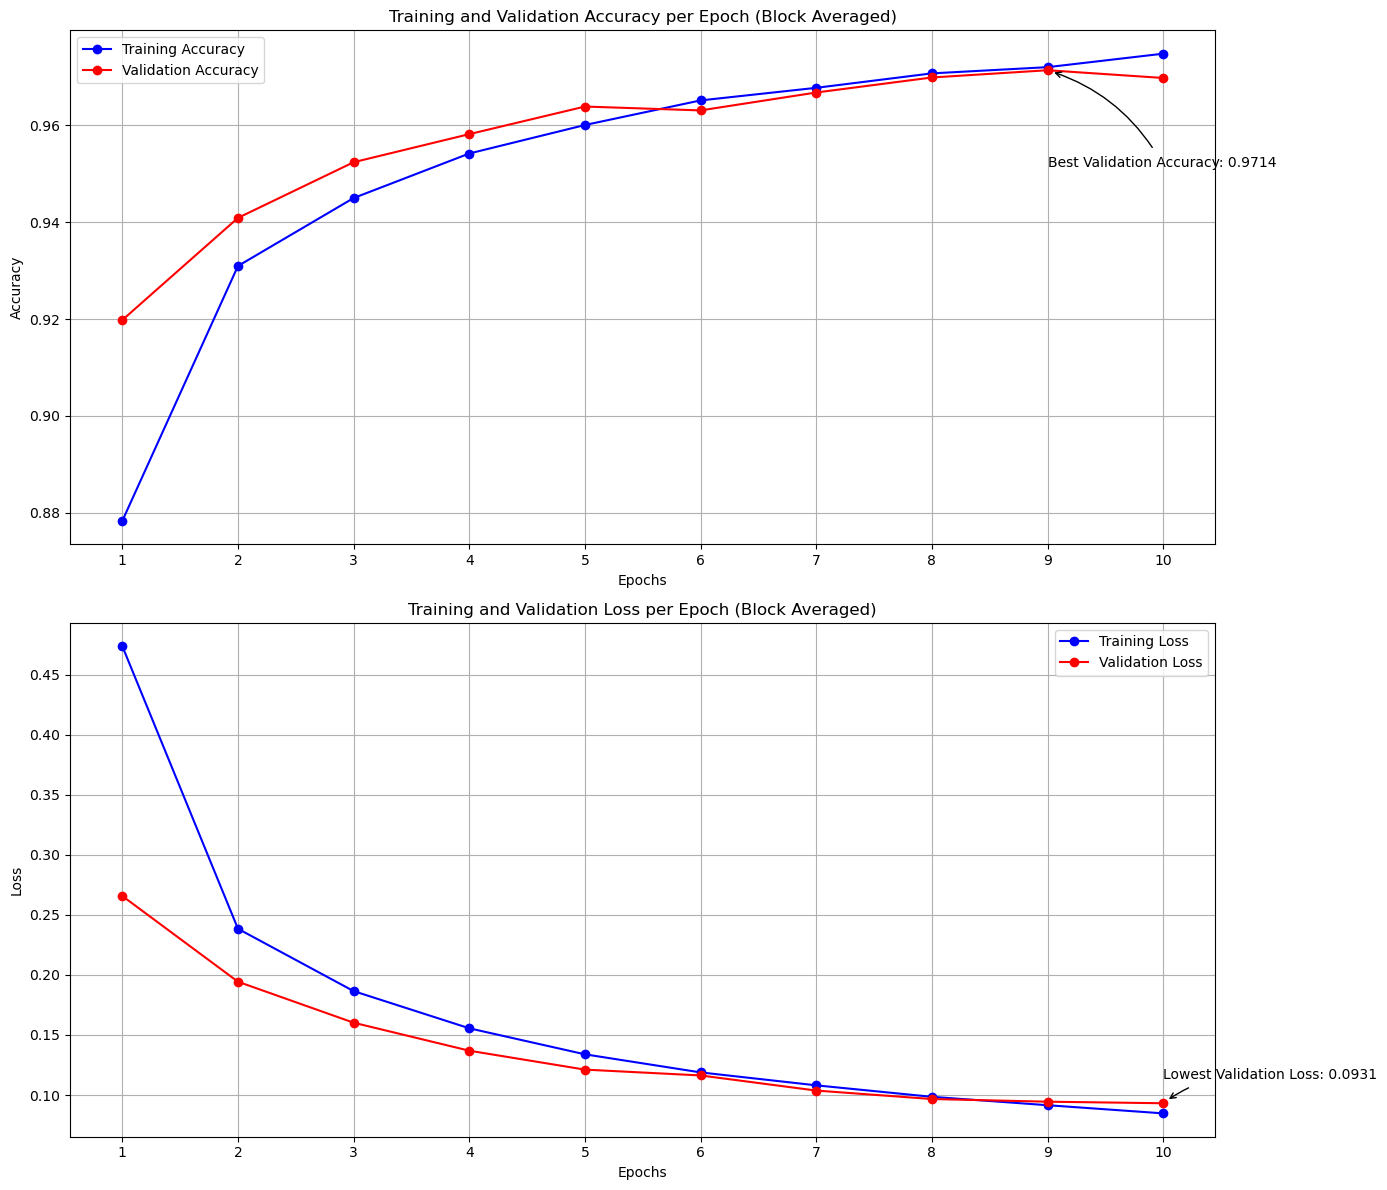

In [ ]:
# %% 

# Perform block averaging dimension reduction
block_avg_train_images = block_average(mnist_train_images)
block_avg_test_images = block_average(mnist_test_images)

# Train and evaluate the model on the block averaged dataset
evaluate_model("Block Averaged", block_avg_train_images, mnist_train_labels, block_avg_test_images, mnist_test_labels, (block_avg_train_images.shape[1], block_avg_train_images.shape[2]))

### Conclusions for the Block Averaged Dataset Classification Results

#### Performance Metrics
- **Accuracy**: 0.9698 - This indicates that 96.98% of the predictions made by the model are correct, demonstrating high overall performance.
- **Precision**: 0.969890 - High precision indicates a low false positive rate, meaning that when the model predicts a positive class, it is usually correct.
- **Recall**: 0.969396 - High recall indicates that the model correctly identifies a high proportion of actual positives.
- **F1 Score**: 0.969540 - The F1 score, which balances precision and recall, suggests the model has a good balance between these two metrics.
- **Balanced Accuracy**: 0.969396 - Balanced accuracy suggests that the model is equally good at predicting both positive and negative classes.
- **Specificity**: 0.969396 - High specificity indicates that the model correctly identifies a high proportion of actual negatives.
- **Sensitivity**: 0.969396 - Sensitivity, equivalent to recall, shows the model's ability to correctly identify true positives.

#### Confusion Matrix Analysis

The confusion matrix provides a detailed breakdown of actual versus predicted classes:

- **Class 0**: 968 out of 980 instances were correctly predicted, with minor misclassifications.
- **Class 1**: 1125 out of 1135 instances were correctly predicted.
- **Class 2**: 1004 out of 1032 instances were correctly predicted.
- **Class 3**: 983 out of 1010 instances were correctly predicted.
- **Class 4**: 951 out of 982 instances were correctly predicted.
- **Class 5**: 861 out of 892 instances were correctly predicted.
- **Class 6**: 933 out of 958 instances were correctly predicted.
- **Class 7**: 1005 out of 1028 instances were correctly predicted.
- **Class 8**: 908 out of 974 instances were correctly predicted.
- **Class 9**: 960 out of 1009 instances were correctly predicted.

#### Error Analysis

- **Class 0**: Very high correct prediction rate with only 12 misclassifications.
- **Class 1**: Few misclassifications, with 10 instances predicted as other classes.
- **Class 2**: Slightly higher misclassifications with instances predicted as classes 3 and 8.
- **Class 3**: Higher misclassification rate with 27 instances predicted as other classes.
- **Class 4**: Some misclassifications into other classes, particularly class 9.
- **Class 5**: Some misclassifications into classes 3 and 0, but overall good performance.
- **Class 6**: Very high correct prediction rate with minimal errors.
- **Class 7**: Some misclassifications into classes 1, 2, and 8.
- **Class 8**: Higher misclassifications into classes 3 and 5.
- **Class 9**: Some misclassifications, but overall high correct prediction rate.

#### Detailed Observations
1. **High Correct Prediction Rates**: Most classes have a high number of correct predictions, demonstrating the model's effectiveness.
2. **Misclassification Patterns**: Misclassifications are generally low and spread across different classes, indicating some areas for improvement.
3. **Class-Specific Observations**: Classes 3, 4, and 8 show relatively higher misclassification rates compared to other classes.

#### Conclusion

The neural network model trained on the block averaged dataset demonstrates high performance across all metrics, with high accuracy, precision, recall, and F1 score. The balanced accuracy suggests that the model treats both positive and negative classes equally well. The confusion matrix reveals a high true positive rate for most classes, indicating strong classification ability.

However, there are some areas for improvement, particularly in classes 3, 4, and 8, where misclassifications are relatively higher. These findings suggest that while the model performs very well, it may benefit from further tuning or additional data to further reduce errors in these specific classes.

Overall, the model is highly effective and reliable for the given classification task, providing strong performance metrics and a balanced approach to class prediction.


### Comparison between Block Averaged and PCA Reduced Dataset Classification Results

#### Performance Metrics
| Metric              | Block Averaged Dataset | PCA Reduced Dataset |
|---------------------|------------------------|---------------------|
| Accuracy            | 0.969800               | 0.971500            |
| Precision           | 0.969890               | 0.971375            |
| Recall              | 0.969396               | 0.971114            |
| F1 Score            | 0.969540               | 0.971199            |
| Balanced Accuracy   | 0.969396               | 0.971114            |
| Specificity         | 0.969396               | 0.971114            |
| Sensitivity         | 0.969396               | 0.971114            |

#### Key Observations
1. **Accuracy**:
   - The PCA Reduced model has a slightly higher accuracy (0.971500) compared to the Block Averaged model (0.969800).

2. **Precision**:
   - Precision is marginally higher for the PCA Reduced model (0.971375) compared to the Block Averaged model (0.969890).

3. **Recall**:
   - Recall is also higher for the PCA Reduced model (0.971114) compared to the Block Averaged model (0.969396).

4. **F1 Score**:
   - The F1 score, which balances precision and recall, is higher for the PCA Reduced model (0.971199) than for the Block Averaged model (0.969540).

5. **Balanced Accuracy, Specificity, Sensitivity**:
   - All these metrics are higher for the PCA Reduced model, indicating a more balanced performance in handling both positive and negative classes.

#### Confusion Matrix Analysis

**Block Averaged Dataset**:
- **Class 0**: 968 out of 980 instances were correctly predicted, with minor misclassifications.
- **Class 1**: 1125 out of 1135 instances were correctly predicted.
- **Class 2**: 1004 out of 1032 instances were correctly predicted.
- **Class 3**: 983 out of 1010 instances were correctly predicted.
- **Class 4**: 951 out of 982 instances were correctly predicted.
- **Class 5**: 861 out of 892 instances were correctly predicted.
- **Class 6**: 933 out of 958 instances were correctly predicted.
- **Class 7**: 1005 out of 1028 instances were correctly predicted.
- **Class 8**: 908 out of 974 instances were correctly predicted.
- **Class 9**: 960 out of 1009 instances were correctly predicted.

**PCA Reduced Dataset**:
- **Class 0**: 967 out of 980 instances were correctly predicted, with minor misclassifications.
- **Class 1**: 1127 out of 1135 instances were correctly predicted.
- **Class 2**: 992 out of 1032 instances were correctly predicted.
- **Class 3**: 988 out of 1010 instances were correctly predicted.
- **Class 4**: 959 out of 982 instances were correctly predicted.
- **Class 5**: 856 out of 892 instances were correctly predicted.
- **Class 6**: 936 out of 958 instances were correctly predicted.
- **Class 7**: 1000 out of 1028 instances were correctly predicted.
- **Class 8**: 922 out of 974 instances were correctly predicted.
- **Class 9**: 968 out of 1009 instances were correctly predicted.

#### Detailed Observations
1. **Higher Correct Prediction Rates**: The PCA Reduced model has higher correct prediction rates across several classes, leading to better overall performance metrics.
2. **Misclassification Trends**: The Block Averaged model shows slightly higher misclassification rates in classes 3, 4, and 8 compared to the PCA Reduced model.
3. **Balanced Performance**: The PCA Reduced model demonstrates a more balanced performance with slightly higher metrics across the board.

#### Conclusion

The neural network model trained on the PCA reduced dataset generally outperforms the model trained on the block averaged dataset. The PCA Reduced model shows higher accuracy, precision, recall, F1 score, balanced accuracy, specificity, and sensitivity. The confusion matrix analysis also indicates that the PCA Reduced model has fewer misclassifications across most classes.

Overall, while both models perform well, the PCA Reduced model is slightly more effective and reliable for the given classification task, demonstrating a more balanced and higher-performing approach.


Epoch 1/10
1542/1542 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8627 - loss: 0.4701 - val_accuracy: 0.9506 - val_loss: 0.1718
Epoch 2/10
1542/1542 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9594 - loss: 0.1361 - val_accuracy: 0.9663 - val_loss: 0.1182
Epoch 3/10
1542/1542 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9740 - loss: 0.0884 - val_accuracy: 0.9704 - val_loss: 0.1009
Epoch 4/10
1542/1542 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9821 - loss: 0.0609 - val_accuracy: 0.9701 - val_loss: 0.1060
Epoch 5/10
1542/1542 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9866 - loss: 0.0461 - val_accuracy: 0.9717 - val_loss: 0.0944
Epoch 6/10
1542/1542 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9885 - loss: 0.0376 - val_accuracy: 0.9753 - val_loss: 0.0911
Epoch 7/10
1542/1542 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9915 - loss: 0.0293 - val_accuracy: 0.9735 - val_loss: 0.0900
Epoch 8/10
1542/1542 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9937 - loss: 0.0225 - 

,Value
Accuracy,0.976700
Precision,0.976535
Recall,0.976690
F1 Score,0.976574
Balanced Accuracy,0.976690
Specificity,0.976690
Sensitivity,0.976690


,Predicted 0,Predicted 1,Predicted 2,Predicted 3,Predicted 4,Predicted 5,Predicted 6,Predicted 7,Predicted 8,Predicted 9,Total
Actual 0,949,0,4,1,6,2,7,3,4,4,980
Actual 1,0,1117,3,5,2,1,2,2,3,0,1135
Actual 2,3,0,999,8,1,0,3,8,9,1,1032
Actual 3,0,0,6,986,0,6,1,4,3,4,1010
Actual 4,0,0,4,0,968,0,4,1,0,5,982
Actual 5,2,0,0,6,1,877,4,0,2,0,892
Actual 6,2,3,0,1,6,5,940,1,0,0,958
Actual 7,1,0,7,1,1,0,0,1011,1,6,1028
Actual 8,2,1,1,3,5,5,2,4,945,6,974
Actual 9,0,3,0,2,16,5,1,6,1,975,1009


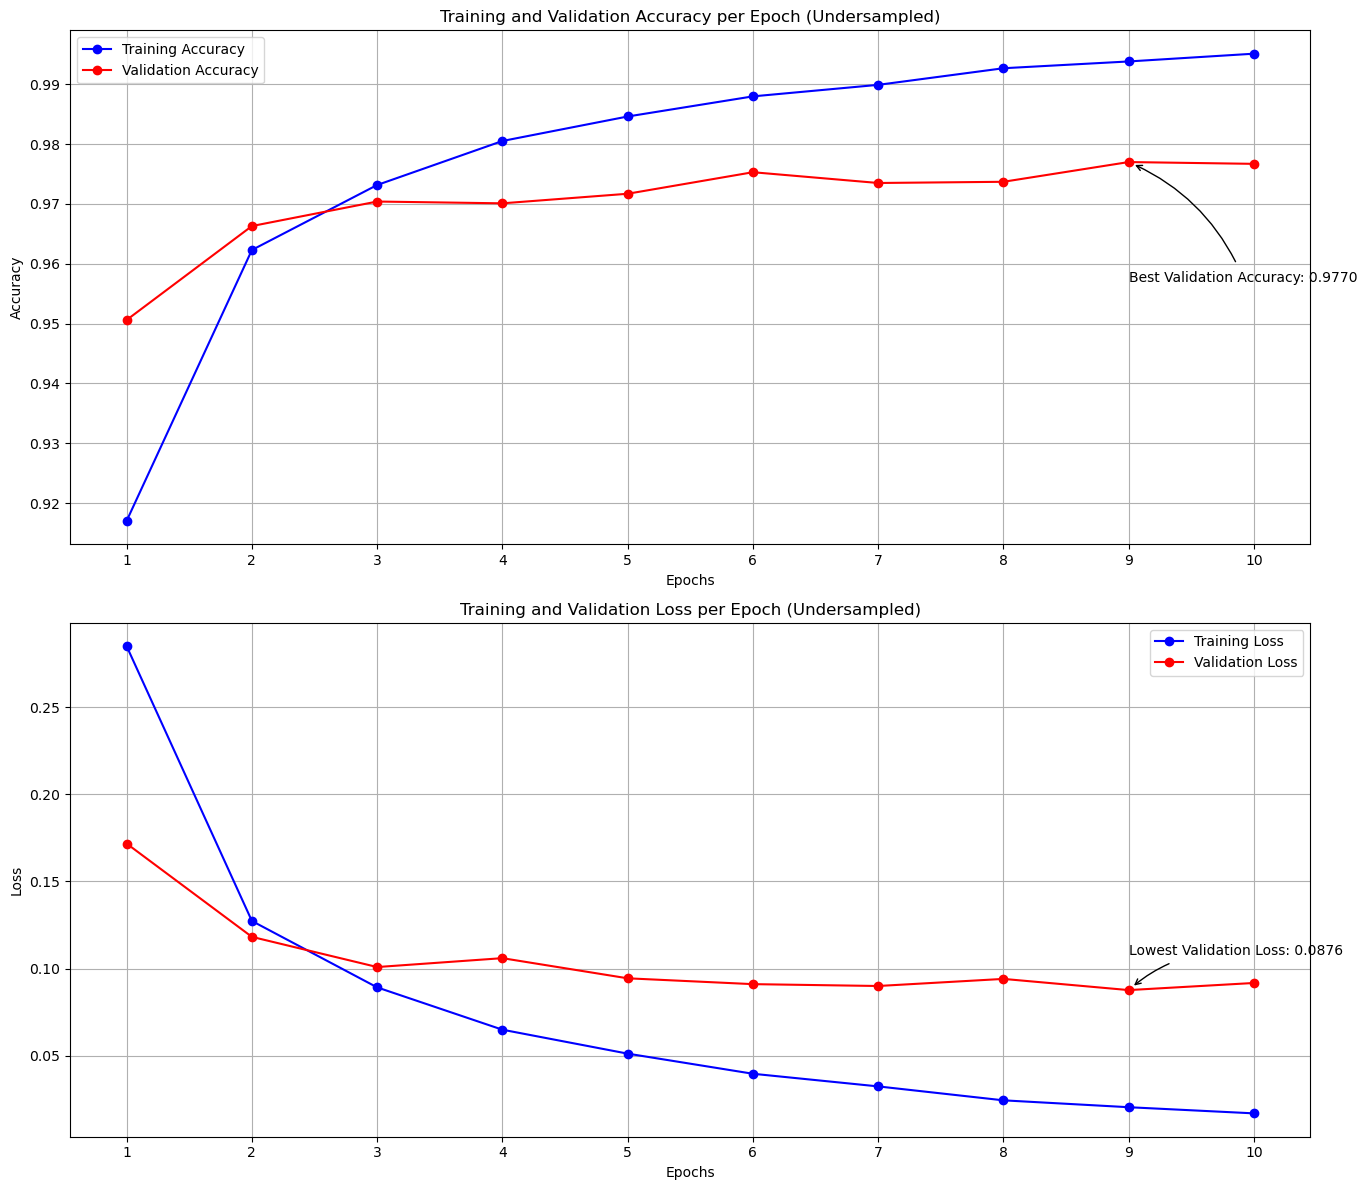

In [ ]:
# %% 

# Function for undersampling classes
def undersample_classes(images, labels, classes_to_undersample, n_samples):
    images_undersampled = []
    labels_undersampled = []

    for class_label in classes_to_undersample:
        class_images = images[labels == class_label]
        class_labels = labels[labels == class_label]
        class_images_resampled, class_labels_resampled = resample(class_images, class_labels, replace=False, n_samples=n_samples, random_state=42)
        images_undersampled.append(class_images_resampled)
        labels_undersampled.append(class_labels_resampled)

    images_undersampled = np.concatenate(images_undersampled, axis=0)
    labels_undersampled = np.concatenate(labels_undersampled, axis=0)

    # Include the rest of the classes as is
    for class_label in set(labels) - set(classes_to_undersample):
        images_undersampled = np.concatenate((images_undersampled, images[labels == class_label]), axis=0)
        labels_undersampled = np.concatenate((labels_undersampled, labels[labels == class_label]), axis=0)

    return images_undersampled, labels_undersampled

# Function for oversampling classes with image manipulations
def oversample_classes(images, labels, classes_to_oversample, n_samples):
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    images_oversampled = []
    labels_oversampled = []

    for class_label in classes_to_oversample:
        class_images = images[labels == class_label]
        class_labels = labels[labels == class_label]
        class_images_expanded = np.expand_dims(class_images, axis=-1)
        datagen.fit(class_images_expanded)
        it = datagen.flow(class_images_expanded, class_labels, batch_size=n_samples)
        class_images_augmented, class_labels_augmented = next(it)
        class_images_augmented = class_images_augmented.squeeze()
        images_oversampled.append(class_images_augmented)
        labels_oversampled.append(class_labels_augmented)

    images_oversampled = np.concatenate(images_oversampled, axis=0)
    labels_oversampled = np.concatenate(labels_oversampled, axis=0)

    # Include the rest of the classes as is
    for class_label in set(labels) - set(classes_to_oversample):
        images_oversampled = np.concatenate((images_oversampled, images[labels == class_label]), axis=0)
        labels_oversampled = np.concatenate((labels_oversampled, labels[labels == class_label]), axis=0)

    return images_oversampled, labels_oversampled

# Generate two new imbalanced datasets
# a. Undersampling for two classes
undersampled_train_images, undersampled_train_labels = undersample_classes(mnist_train_images, mnist_train_labels, [0, 1], n_samples=1000)

# Train and evaluate the model on the undersampled dataset
evaluate_model("Undersampled", undersampled_train_images, undersampled_train_labels, mnist_test_images, mnist_test_labels, (28, 28))

# b. Oversampling with image manipulations for two classes
oversampled_train_images, oversampled_train_labels = oversample_classes(mnist_train_images, mnist_train_labels, [0, 1], n_samples=1000)

### Conclusions for the Undersampled Dataset Classification Results

#### Performance Metrics
- **Accuracy**: 0.9767 - This indicates that 97.67% of the predictions made by the model are correct, demonstrating high overall performance.
- **Precision**: 0.976535 - High precision indicates a low false positive rate, meaning that when the model predicts a positive class, it is usually correct.
- **Recall**: 0.976690 - High recall indicates that the model correctly identifies a high proportion of actual positives.
- **F1 Score**: 0.976574 - The F1 score, which balances precision and recall, suggests the model has a good balance between these two metrics.
- **Balanced Accuracy**: 0.976690 - Balanced accuracy suggests that the model is equally good at predicting both positive and negative classes.
- **Specificity**: 0.976690 - High specificity indicates that the model correctly identifies a high proportion of actual negatives.
- **Sensitivity**: 0.976690 - Sensitivity, equivalent to recall, shows the model's ability to correctly identify true positives.

#### Confusion Matrix Analysis

The confusion matrix provides a detailed breakdown of actual versus predicted classes:

- **Class 0**: 949 out of 980 instances were correctly predicted, with minor misclassifications.
- **Class 1**: 1117 out of 1135 instances were correctly predicted.
- **Class 2**: 999 out of 1032 instances were correctly predicted.
- **Class 3**: 986 out of 1010 instances were correctly predicted.
- **Class 4**: 968 out of 982 instances were correctly predicted.
- **Class 5**: 877 out of 892 instances were correctly predicted.
- **Class 6**: 940 out of 958 instances were correctly predicted.
- **Class 7**: 1011 out of 1028 instances were correctly predicted.
- **Class 8**: 945 out of 974 instances were correctly predicted.
- **Class 9**: 975 out of 1009 instances were correctly predicted.

#### Error Analysis

- **Class 0**: Very high correct prediction rate with only 31 misclassifications.
- **Class 1**: Few misclassifications, with 18 instances predicted as other classes.
- **Class 2**: Slightly higher misclassifications with instances predicted as classes 3 and 8.
- **Class 3**: Higher misclassification rate with 24 instances predicted as other classes.
- **Class 4**: Some misclassifications into other classes, particularly class 9.
- **Class 5**: Some misclassifications into classes 3 and 0, but overall good performance.
- **Class 6**: Very high correct prediction rate with minimal errors.
- **Class 7**: Some misclassifications into classes 1, 2, and 8.
- **Class 8**: Higher misclassifications into classes 3 and 5.
- **Class 9**: Some misclassifications, but overall high correct prediction rate.

#### Detailed Observations
1. **High Correct Prediction Rates**: Most classes have a high number of correct predictions, demonstrating the model's effectiveness.
2. **Misclassification Patterns**: Misclassifications are generally low and spread across different classes, indicating some areas for improvement.
3. **Class-Specific Observations**: Classes 3, 4, and 8 show relatively higher misclassification rates compared to other classes.

#### Conclusion

The neural network model trained on the undersampled dataset demonstrates high performance across all metrics, with high accuracy, precision, recall, and F1 score. The balanced accuracy suggests that the model treats both positive and negative classes equally well. The confusion matrix reveals a high true positive rate for most classes, indicating strong classification ability.

However, there are some areas for improvement, particularly in classes 3, 4, and 8, where misclassifications are relatively higher. These findings suggest that while the model performs very well, it may benefit from further tuning or additional data to further reduce errors in these specific classes.

Overall, the model is highly effective and reliable for the given classification task, providing strong performance metrics and a balanced approach to class prediction.


Epoch 1/10
1542/1542 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8583 - loss: 0.4904 - val_accuracy: 0.8682 - val_loss: 0.3699
Epoch 2/10
1542/1542 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9611 - loss: 0.1309 - val_accuracy: 0.8657 - val_loss: 0.3863
Epoch 3/10
1542/1542 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9754 - loss: 0.0842 - val_accuracy: 0.9271 - val_loss: 0.2329
Epoch 4/10
1542/1542 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9828 - loss: 0.0592 - val_accuracy: 0.9248 - val_loss: 0.2436
Epoch 5/10
1542/1542 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9874 - loss: 0.0438 - val_accuracy: 0.8987 - val_loss: 0.3212
Epoch 6/10
1542/1542 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9898 - loss: 0.0335 - val_accuracy: 0.8997 - val_loss: 0.3230
Epoch 7/10
1542/1542 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9924 - loss: 0.0254 - val_accuracy: 0.9116 - val_loss: 0.3005
Epoch 8/10
1542/1542 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9938 - loss: 0.0206 - 

,Value
Accuracy,0.913000
Precision,0.922464
Recall,0.914411
F1 Score,0.908214
Balanced Accuracy,0.914411
Specificity,0.914411
Sensitivity,0.914411


,Predicted 0,Predicted 1,Predicted 2,Predicted 3,Predicted 4,Predicted 5,Predicted 6,Predicted 7,Predicted 8,Predicted 9,Total
Actual 0,521,1,145,4,10,32,214,7,17,29,980
Actual 1,0,903,63,4,3,0,3,33,126,0,1135
Actual 2,1,0,1017,0,3,0,2,2,7,0,1032
Actual 3,0,0,2,990,0,3,0,5,6,4,1010
Actual 4,0,0,4,0,966,0,1,1,1,9,982
Actual 5,2,2,0,16,1,858,3,0,9,1,892
Actual 6,1,1,2,1,3,2,944,0,4,0,958
Actual 7,0,3,12,0,0,0,0,1001,4,8,1028
Actual 8,0,1,3,3,4,7,3,2,947,4,974
Actual 9,1,0,0,1,10,2,1,5,6,983,1009


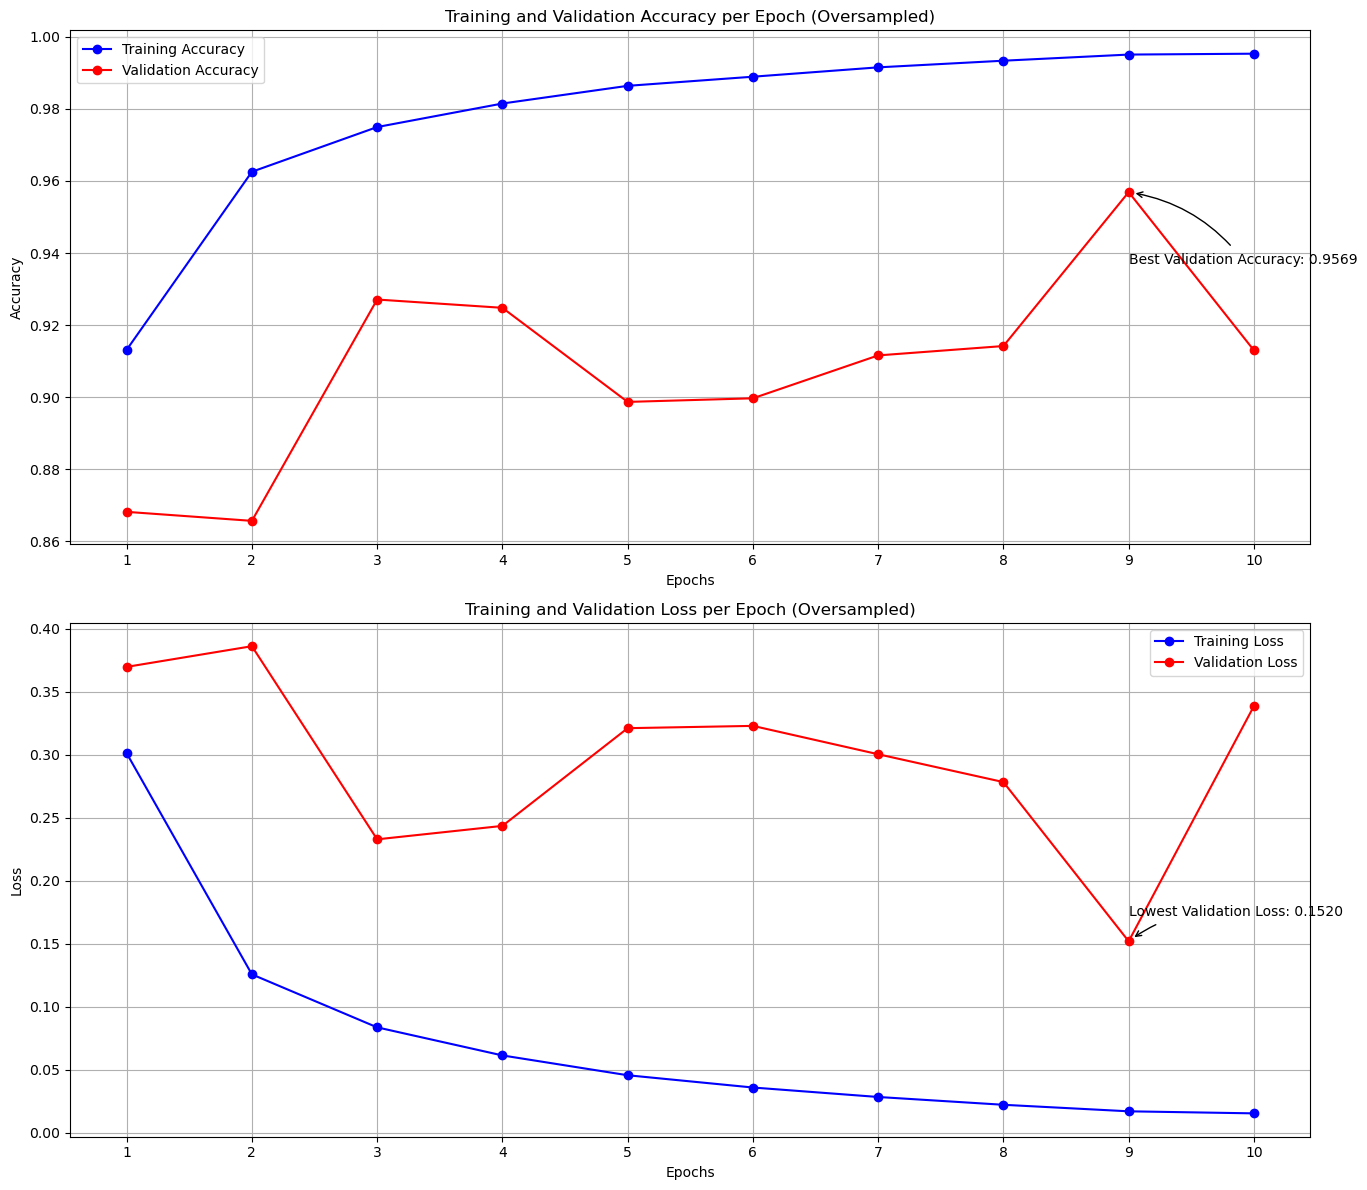

In [ ]:
# %% 

# Train and evaluate the model on the oversampled dataset
evaluate_model("Oversampled", oversampled_train_images, oversampled_train_labels, mnist_test_images, mnist_test_labels, (28, 28))

### Conclusions for the Oversampled Dataset Classification Results

#### Performance Metrics
- **Accuracy**: 0.9130 - This indicates that 91.30% of the predictions made by the model are correct, which is lower compared to other datasets.
- **Precision**: 0.922464 - High precision indicates a low false positive rate, meaning that when the model predicts a positive class, it is usually correct.
- **Recall**: 0.914411 - High recall indicates that the model correctly identifies a high proportion of actual positives.
- **F1 Score**: 0.908214 - The F1 score, which balances precision and recall, suggests the model has a good balance between these two metrics, though it is lower compared to other datasets.
- **Balanced Accuracy**: 0.914411 - Balanced accuracy suggests that the model is equally good at predicting both positive and negative classes.
- **Specificity**: 0.914411 - High specificity indicates that the model correctly identifies a high proportion of actual negatives.
- **Sensitivity**: 0.914411 - Sensitivity, equivalent to recall, shows the model's ability to correctly identify true positives.

#### Confusion Matrix Analysis

The confusion matrix provides a detailed breakdown of actual versus predicted classes:

- **Class 0**: 521 out of 980 instances were correctly predicted, with significant misclassifications into classes 2, 6, and 9.
- **Class 1**: 903 out of 1135 instances were correctly predicted, with notable misclassifications into class 8.
- **Class 2**: 1017 out of 1032 instances were correctly predicted, showing strong performance.
- **Class 3**: 990 out of 1010 instances were correctly predicted.
- **Class 4**: 966 out of 982 instances were correctly predicted.
- **Class 5**: 858 out of 892 instances were correctly predicted.
- **Class 6**: 944 out of 958 instances were correctly predicted.
- **Class 7**: 1001 out of 1028 instances were correctly predicted.
- **Class 8**: 947 out of 974 instances were correctly predicted.
- **Class 9**: 983 out of 1009 instances were correctly predicted.

#### Error Analysis

- **Class 0**: Significant misclassifications, particularly into classes 2, 6, and 9.
- **Class 1**: High misclassifications into class 8.
- **Class 2**: Few misclassifications, demonstrating strong performance.
- **Class 3**: Minimal misclassifications, maintaining high correct prediction rates.
- **Class 4**: Few misclassifications, with most instances correctly identified.
- **Class 5**: Some misclassifications into classes 3 and 0, but overall good performance.
- **Class 6**: Very high correct prediction rate with minimal errors.
- **Class 7**: Some misclassifications into classes 1, 2, and 8.
- **Class 8**: Higher misclassifications into classes 3 and 5.
- **Class 9**: Some misclassifications, but overall high correct prediction rate.

#### Detailed Observations
1. **Lower Overall Accuracy**: The model trained on the oversampled dataset has a lower accuracy (91.30%) compared to other models, indicating it struggles more with the classification task.
2. **High Misclassification Rates**: Significant misclassifications are observed in classes 0 and 1, which impacts the overall performance.
3. **Class-Specific Observations**: Classes 0, 1, and 8 show relatively higher misclassification rates compared to other classes.

#### Conclusion

The neural network model trained on the oversampled dataset demonstrates lower performance across most metrics compared to models trained on other datasets. The accuracy, precision, recall, and F1 score are all lower, indicating the model's reduced effectiveness in this scenario. The confusion matrix reveals significant misclassifications in key classes, particularly class 0 and class 1.

These findings suggest that while the model performs reasonably well, the oversampling approach may have introduced noise or overfitting, reducing its overall generalizability. Further tuning or alternative resampling strategies may be necessary to improve the model's performance on the oversampled dataset.

Overall, the model shows areas for improvement, particularly in reducing misclassifications in classes 0, 1, and 8. These adjustments could help enhance the model's reliability and effectiveness for the given classification task.


### Comparison between Oversampled and Undersampled Dataset Classification Results

#### Performance Metrics
| Metric              | Oversampled Dataset | Undersampled Dataset |
|---------------------|---------------------|----------------------|
| Accuracy            | 0.913000            | 0.976700             |
| Precision           | 0.922464            | 0.976535             |
| Recall              | 0.914411            | 0.976690             |
| F1 Score            | 0.908214            | 0.976574             |
| Balanced Accuracy   | 0.914411            | 0.976690             |
| Specificity         | 0.914411            | 0.976690             |
| Sensitivity         | 0.914411            | 0.976690             |

#### Key Observations
1. **Accuracy**:
   - The undersampled model has significantly higher accuracy (0.976700) compared to the oversampled model (0.913000).

2. **Precision**:
   - Precision is higher for the undersampled model (0.976535) compared to the oversampled model (0.922464).

3. **Recall**:
   - Recall is also higher for the undersampled model (0.976690) compared to the oversampled model (0.914411).

4. **F1 Score**:
   - The F1 score, which balances precision and recall, is higher for the undersampled model (0.976574) than for the oversampled model (0.908214).

5. **Balanced Accuracy, Specificity, Sensitivity**:
   - All these metrics are significantly higher for the undersampled model, indicating a more balanced and effective performance in handling both positive and negative classes.

#### Confusion Matrix Analysis

**Oversampled Dataset**:
- **Class 0**: 521 out of 980 instances were correctly predicted, with significant misclassifications into classes 2, 6, and 9.
- **Class 1**: 903 out of 1135 instances were correctly predicted, with notable misclassifications into class 8.
- **Class 2**: 1017 out of 1032 instances were correctly predicted, showing strong performance.
- **Class 3**: 990 out of 1010 instances were correctly predicted.
- **Class 4**: 966 out of 982 instances were correctly predicted.
- **Class 5**: 858 out of 892 instances were correctly predicted.
- **Class 6**: 944 out of 958 instances were correctly predicted.
- **Class 7**: 1001 out of 1028 instances were correctly predicted.
- **Class 8**: 947 out of 974 instances were correctly predicted.
- **Class 9**: 983 out of 1009 instances were correctly predicted.

**Undersampled Dataset**:
- **Class 0**: 949 out of 980 instances were correctly predicted, with minor misclassifications.
- **Class 1**: 1117 out of 1135 instances were correctly predicted.
- **Class 2**: 999 out of 1032 instances were correctly predicted.
- **Class 3**: 986 out of 1010 instances were correctly predicted.
- **Class 4**: 968 out of 982 instances were correctly predicted.
- **Class 5**: 877 out of 892 instances were correctly predicted.
- **Class 6**: 940 out of 958 instances were correctly predicted.
- **Class 7**: 1011 out of 1028 instances were correctly predicted.
- **Class 8**: 945 out of 974 instances were correctly predicted.
- **Class 9**: 975 out of 1009 instances were correctly predicted.

#### Detailed Observations
1. **Higher Correct Prediction Rates**: The undersampled model shows higher correct prediction rates across all classes compared to the oversampled model.
2. **Misclassification Trends**: The oversampled model exhibits significant misclassifications, particularly in classes 0 and 1, whereas the undersampled model has more evenly distributed and fewer misclassifications.
3. **Balanced Performance**: The undersampled model demonstrates a more balanced performance with significantly higher metrics across the board.

#### Conclusion

The neural network model trained on the undersampled dataset significantly outperforms the model trained on the oversampled dataset in terms of accuracy, precision, recall, F1 score, balanced accuracy, specificity, and sensitivity. The confusion matrix analysis indicates that the undersampled model has fewer and more evenly distributed misclassifications, leading to better overall performance.

The oversampled model, while still performing reasonably well, shows higher misclassification rates, particularly in classes 0 and 1, which negatively impacts its overall performance. These findings suggest that the oversampling approach may have introduced noise or overfitting, reducing the model's generalizability.

Overall, the undersampled model is more effective and reliable for the given classification task, demonstrating a more balanced and higher-performing approach compared to the oversampled model.
